# Comparing Subgroups of Edges

In [91]:
import pandas as pd
import graspologic as gp
import seaborn as sns
import hyppo
import matplotlib.pyplot as plt
import numpy as np
from graphbook_code import heatmap, cmaps

import matplotlib.cm

from sklearn.preprocessing import LabelEncoder

In [18]:
## Read the data

key = pd.read_csv('../data/processed/key.csv')
data = pd.read_csv('../data/processed/mouses-volumes.csv')
fa = pd.read_csv('../data/processed/mouses-fa.csv')

data.set_index(key.DWI, inplace=True)
fa.set_index(key.DWI, inplace=True)

genotypes = ['APOE22', 'APOE33', 'APOE44']


gen_animals = {genotype: None for genotype in genotypes}

for genotype in genotypes:
    gen_animals[genotype] = key.loc[key['Genotype'] == genotype]['DWI'].tolist()

vol_dat = {genotype: [] for genotype in genotypes}
fa_dat = {genotype: [] for genotype in genotypes}
for genotype in genotypes:
    vol_dat[genotype] = data.loc[gen_animals[genotype]].to_numpy()
    fa_dat[genotype] = fa.loc[gen_animals[genotype]].to_numpy()
    
## Compute correlations
vol_cor = {genotype: gp.utils.symmetrize(np.corrcoef(dat, rowvar=False)) for (genotype, dat) in vol_dat.items()}
fa_cor = {genotype: gp.utils.symmetrize(np.corrcoef(dat, rowvar=False)) for (genotype, dat) in fa_dat.items()}


node_labels = pd.read_csv("../data/processed/node_label_dictionary.csv")
node_labels["Hem"] = node_labels["Hemisphere"].map({"Left": "L", "Right": "R"})
node_labels["L1"] = node_labels["Level_1"].map({"1_forebrain": "F", "2_midbrain": "M",
                                                   "3_hindbrain": "H", "4_white_matter_tracts": "W",
                                                   "5_ventricular_system": "V"})
node_labels["Label"] = node_labels["Hem"] + node_labels["L1"]

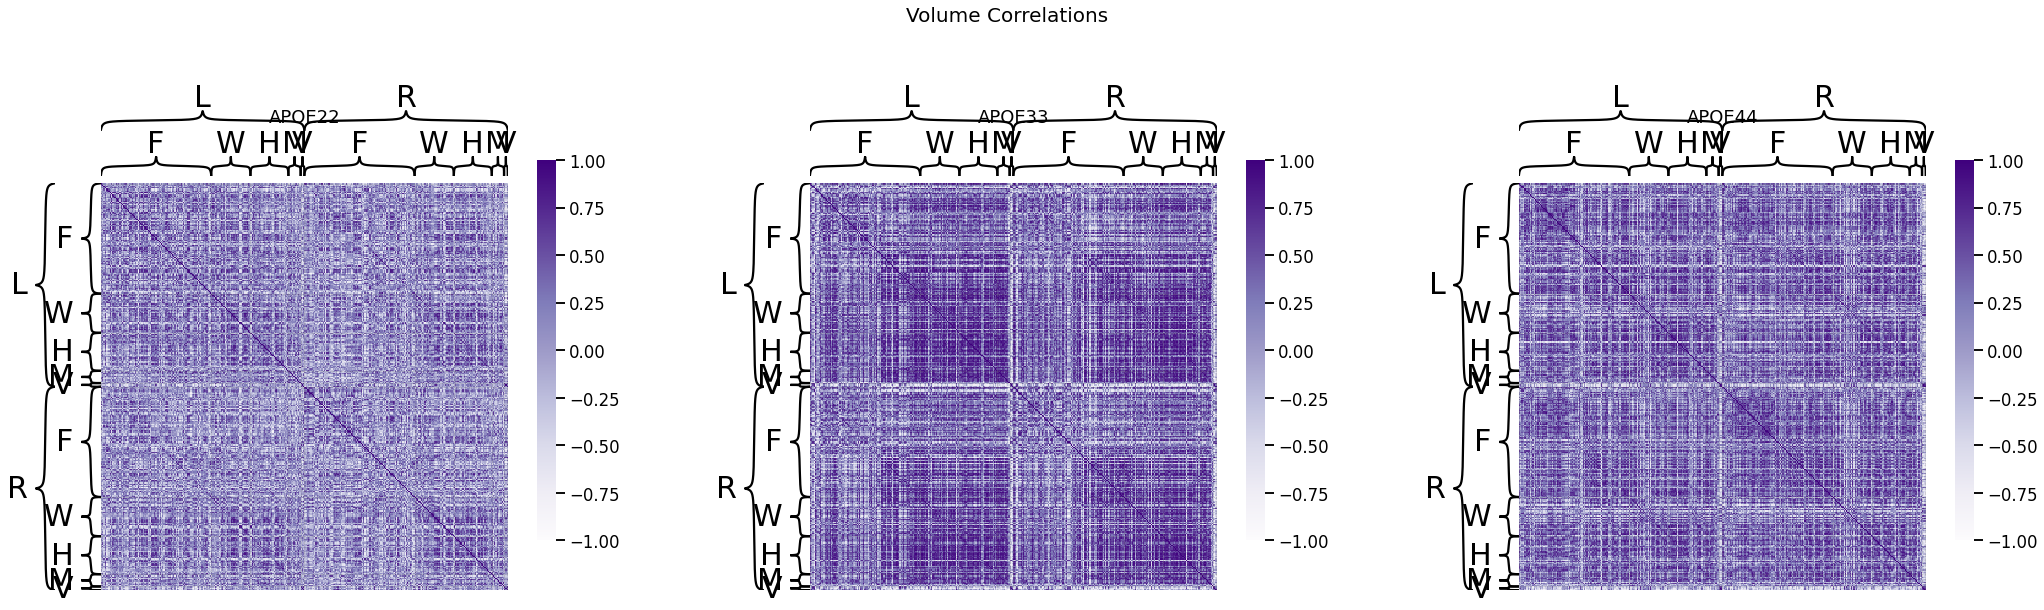

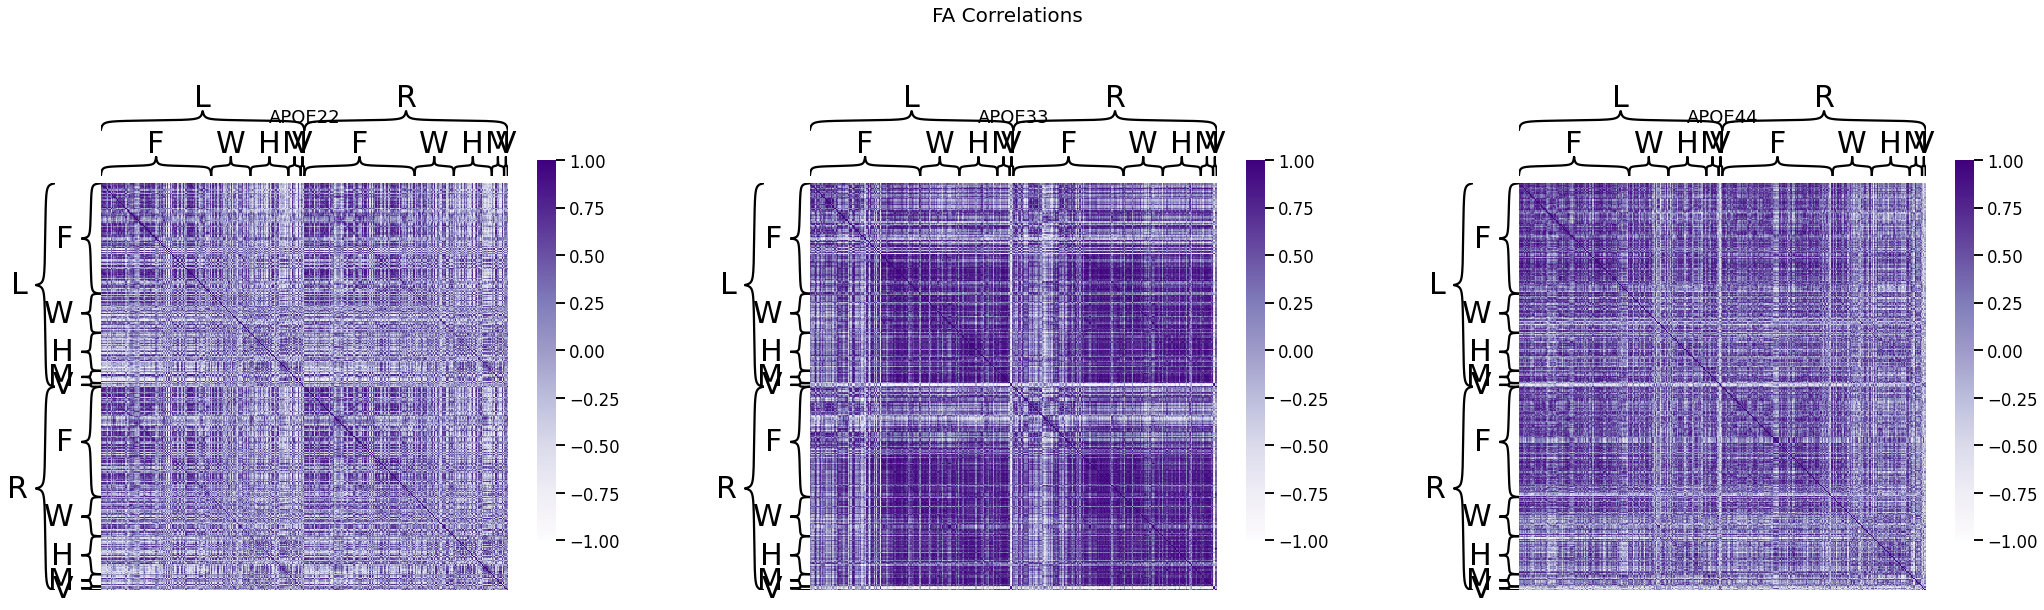

In [22]:
## Plot to make sure nothing is wrong

## Node hierarchical label data
fig, ax = plt.subplots(1, 3, figsize=(36, 10))
for (i, genotype) in enumerate(vol_cor.keys()):
    fig.suptitle("Volume Correlations", fontsize=20)
    heatmap(vol_cor[genotype], title=genotype, outer_hier_labels=node_labels["Hem"],
            inner_hier_labels=node_labels["L1"], ax=ax[i], vmin=-1, vmax=1)

fig, ax = plt.subplots(1, 3, figsize=(36, 10))
for (i, genotype) in enumerate(fa_cor.keys()):
    fig.suptitle("FA Correlations",  fontsize=20)
    heatmap(fa_cor[genotype], title=genotype, outer_hier_labels=node_labels["Hem"],
            inner_hier_labels=node_labels["L1"], ax=ax[i], vmin=-1, vmax=1)

## Statistical Experiment

For a given pair of sub-regions (Left/Right Forebrain, Midbrain, Hindbrain, White Matter Tracts) $k$ and $l$, do the edges incident nodes between a pair of communities have the same, or a different, distribution? Formally, consider the following model. Let $a_{ij}^{(y)}$ be the edge-weight for edge $i, j$, and let $z_i \in [K]$ be the node label for node $i$, where $y \in \{APOE22, APOE33, APOE44\}$ is the class of the network:

\begin{align*}
    a_{ij}^{(y)} | z_i = k, z_j = l \overset{ind.}{\sim} F^{(y)}_{k,l}
\end{align*}

where $F^{(y)}_{k,l}$ is the distribution function for the community of edges $k$ and $l$ in a network of class $y$. For a given tuple of node communities $(k,l)$ and $(k',l')$, the hypothesis of interest is:
\begin{align*}
    H_{0, k, l}^{(y, y')} : F^{(y)}_{k,l} = F^{(y')}_{k,l} \text{ against }H^{(y)}_{A, k,l}: F^{(y)}_{k,l} = F^{(y')}_{k,l}
\end{align*}

The interpretation of a $p$-value less than the cutoff threshold $\alpha = 0.05$ (after Bonferroni-Holm adjustment) for a given pair of classes $(y, y')$ at a given community pair $(k, l)$ is that the data does not support the null hypothesis, that the community pairing shares an equal distribution between the indicated pair of classes. A sufficient test for this context (univariate data, assumed to be independent, paired) is the Wilcoxon Signed-Rank Test, which can be performed using `scipy`.

The outcomes (p-values) can be visualized as pairs of heatmaps between a given pair of classes. Further, since the edges are undirected, we can ignore the off-diagonals of the matrix. These outcomes are then ranked, where a large rank indicates the smaller p-values.

In [137]:
from scipy.stats import wilcoxon
from itertools import combinations

results = []

nodelabs = node_labels["Label"]

for (y, yp) in list(combinations(genotypes, 2)):
    for (k, l) in combinations(np.unique(node_labels["Label"]), 2):
        statv, pvalv = wilcoxon(vol_cor[y][nodelabs == k,:][:,nodelabs == l].flatten(),
                                   vol_cor[yp][nodelabs == k,:][:,nodelabs == l].flatten())
        statfa, pvalfa = wilcoxon(fa_cor[y][nodelabs == k,:][:,nodelabs == l].flatten(),
                                     fa_cor[yp][nodelabs == k,:][:,nodelabs == l].flatten())
        results.append({"Pairing": "{:s} to {:s}".format(y, yp),
                        "Community k": k, "Community l": l,
                        "p-value(Vol)": pvalv, "Statistic(Vol)": statv,
                        "p-value(FA)": pvalfa, "Statistic(FA)": statfa})
res_dat = pd.DataFrame(results)
res_dat["Pairing"] = res_dat["Pairing"].astype("category")
res_dat["Community k"] = res_dat["Community k"].astype("category")
res_dat["Community l"] = res_dat["Community l"].astype("category")

In [138]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import rankdata

pvals = np.hstack((np.array(res_dat["p-value(Vol)"]), np.array(res_dat["p-value(FA)"])))
pvals_adjusted = multipletests(pvals, method="holm")[1]

len_pvals = res_dat.shape[0]
res_dat["p-value(Vol)"] = pvals_adjusted[0:len_pvals]
res_dat["p-value(FA)"] = pvals_adjusted[len_pvals:(2*len_pvals)]

res_dat["rank(Vol)"] = rankdata(-res_dat["p-value(Vol)"])
res_dat["rank(FA)"] = rankdata(-res_dat["p-value(FA)"])
alpha = .05
res_dat["Test Outcome(Vol)"] = res_dat["p-value(Vol)"] < alpha
res_dat["Test Outcome(FA)"] = res_dat["p-value(FA)"] < alpha

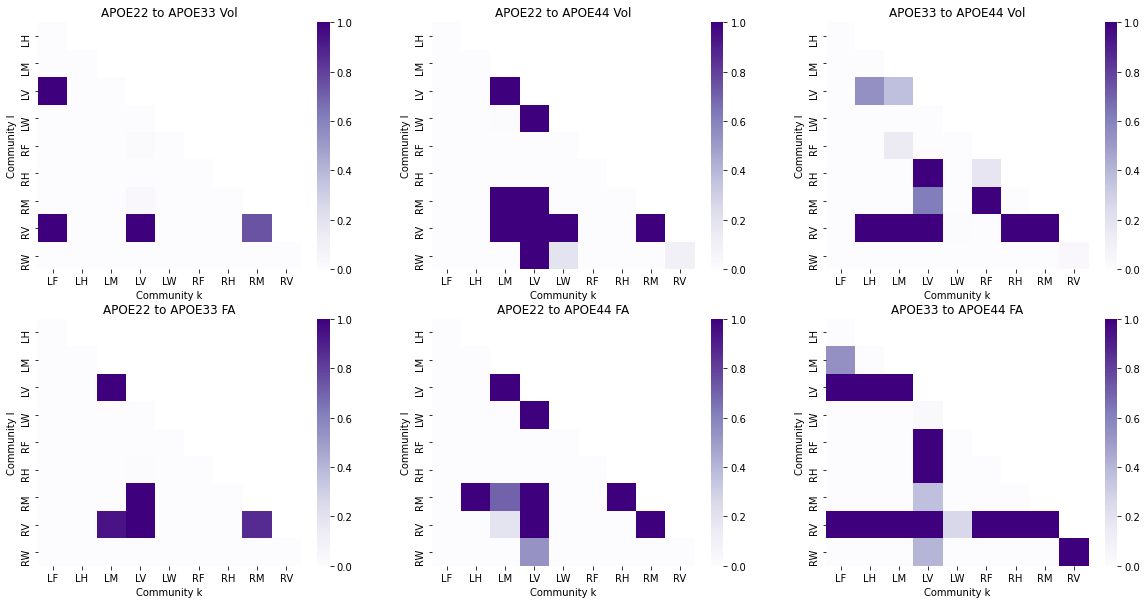

In [139]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, pairing in enumerate(np.unique(res_dat["Pairing"])):
    df_X = res_dat.loc[res_dat["Pairing"] == pairing].pivot("Community l", "Community k", "p-value(Vol)")
    ax = sns.heatmap(df_X, ax=axs[0, i], cmap=cmaps["sequential"])
    ax.set_title("{:s} Vol".format(pairing))
    df_X = res_dat.loc[res_dat["Pairing"] == pairing].pivot("Community l", "Community k", "p-value(FA)")
    ax = sns.heatmap(df_X, ax=axs[1, i], cmap=cmaps["sequential"])
    ax.set_title("{:s} FA".format(pairing))

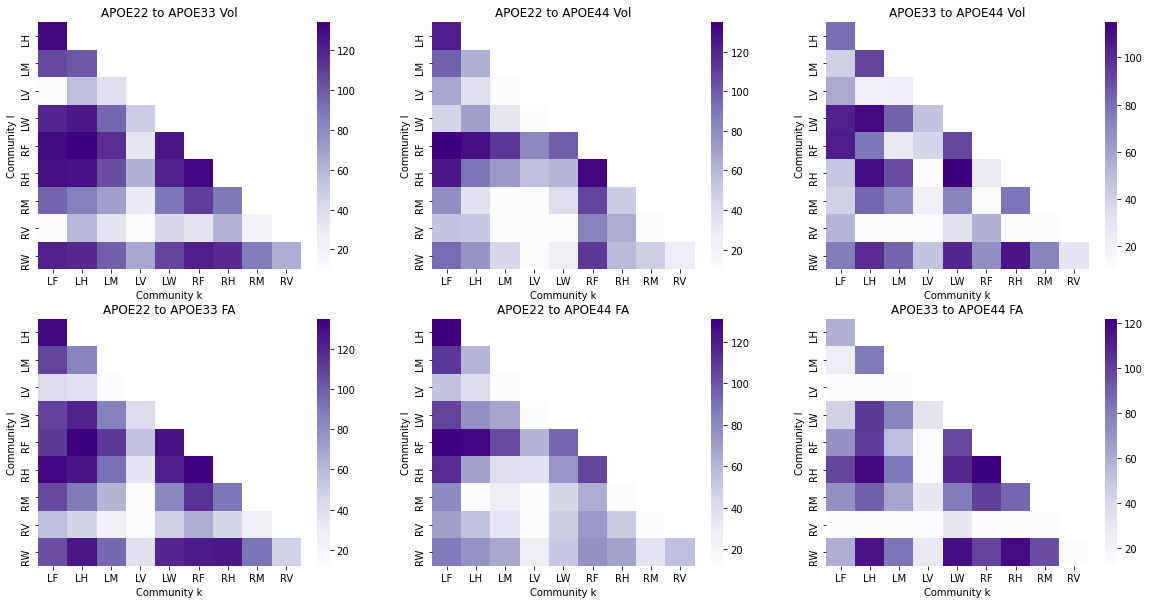

In [140]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, pairing in enumerate(np.unique(res_dat["Pairing"])):
    df_X = res_dat.loc[res_dat["Pairing"] == pairing].pivot("Community l", "Community k", "rank(Vol)")
    ax = sns.heatmap(df_X, ax=axs[0, i], cmap=cmaps["sequential"])
    ax.set_title("{:s} Vol".format(pairing))
    df_X = res_dat.loc[res_dat["Pairing"] == pairing].pivot("Community l", "Community k", "rank(FA)")
    ax = sns.heatmap(df_X, ax=axs[1, i], cmap=cmaps["sequential"])
    ax.set_title("{:s} FA".format(pairing))